# Experiment with extracting shape info from confocal images of fish embryos

In [42]:
from aicsimageio import AICSImage
import os 

# define save paths
image_name = "1C_LM010_RT_kikume"
read_path = "/Users/nick/Dropbox (Cole Trapnell's Lab)/Nick/morphMap/data/yx1_samples/20230322/RT/"
image_path = read_path + image_name + ".nd2"
pcd_path = "/Users/nick/Dropbox (Cole Trapnell's Lab)/Nick/morphMap/data/yx1_pcd/20230322/RT/"

# make save directory
if not os.path.isdir(pcd_path):
    os.makedirs(pcd_path)

# load image
imObject = AICSImage(image_path)

In [43]:
# upsample along z axis
import scipy
import numpy as np

# get resolution
res_raw = imObject.physical_pixel_sizes
res_array = np.asarray(res_raw)
res_array = np.insert(res_array, 0, 1)
pixel_size_z = res_array[1]
pixel_size_x = res_array[2]
pixel_size_y = res_array[3]

# extract raw image
imData = np.squeeze(imObject.data)

# resize image such that voxels are isotropic
z_rs_factor = pixel_size_z/pixel_size_x
ds_factor = 2
pixel_size_new = pixel_size_x / ds_factor
imData_rs = scipy.ndimage.zoom(imData, [z_rs_factor/ds_factor, 1/ds_factor, 1/ds_factor])

## Step1: segment 2D region that contains the embryo

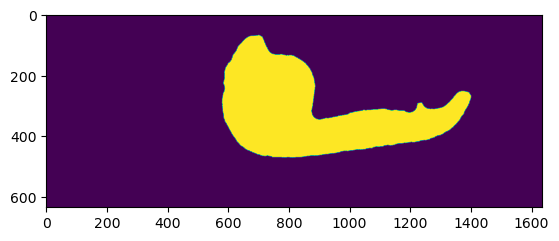

In [45]:
import plotly.graph_objects as go
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)
import plotly.express as px
from skimage import data
from skimage import filters
from skimage.segmentation import active_contour
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import black_tophat, skeletonize, convex_hull_image 
from skimage.morphology import disk
import skimage

# find brightest pixel
max_pos_z = np.argmax(imData_rs, axis=0)
max_brightness_z = np.max(imData_rs, axis=0)

# Calculate threshold
# threshold_ni = filters.threshold_niblack(max_brightness_z, window_size=51)
# threshold_ot = filters.threshold_otsu(max_brightness_z)
threshold_sa = filters.threshold_sauvola(max_brightness_z, window_size=11)

# this should result in a sparse cloud of white regions that jointly define the embryo body
fish_mask = (max_brightness_z < threshold_sa)*1

# use morphological closure operation to fill in shape
footprint = disk(13)
fish_closed = closing(fish_mask, footprint)

# remove small objects 
fish_strip = skimage.morphology.remove_small_objects(label(fish_closed), min_size=64)

# erode to
fish_clean = skimage.morphology.binary_erosion(fish_strip, footprint)
                   
# generate x and y reference grids
x_grid, y_grid = np.meshgrid(range(0, imData_rs.shape[2]), range(0, imData_rs.shape[1]))
# x_points = x_grid[np.where(fish_clean==1)]
# y_points = y_grid[np.where(fish_clean==1)]
# xy_in = np.concatenate((np.reshape(x_points, (x_points.size, 1)), 
#                         np.reshape(y_points, (y_points.size, 1))), axis=1)
# # xy_in = [(x_points[i], y_points[i]) for i in range(x_points.size)]

# fig = px.scatter(x=xy_in[:, 0], 
#                  y=xy_in[:, 1])

# fig.show()
plt.imshow(fish_clean)


**Apply 2D mask to the full 3D image.** Then, apply thresholding to find the first "inside" pixel in each xy column

In [ ]:
# # calculate pixel-specific thresholds 
# threshold_3D_sa = filters.threshold_niblack(imData_rs, window_size=51)
# imData_thresh = (imData_rs > threshold_3D_sa)*1

# # apply mask
# imData_masked = np.multiply(fish_clean, imData_thresh)

# plt.imshow(imData_masked[20, :, :])

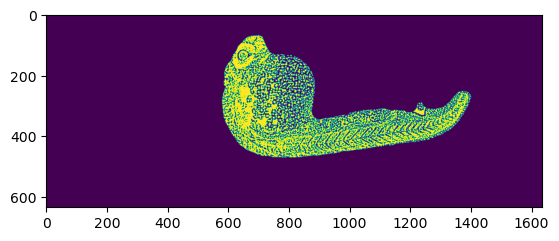

In [46]:
# generate final 2D mask that dictates which mixels are and are not counted
threshold_sa_2 = filters.threshold_sauvola(max_brightness_z, window_size=11)
# bkd = np.percentile(max_brightness_z[np.where(fish_clean != 1)], 99)
imData2D_thresh = (max_brightness_z > threshold_sa_2)*1
imData2D_masked = np.multiply(fish_clean, imData2D_thresh)
# footprint_small = disk(1)
# imData2D_masked = skimage.morphology.binary_erosion(imData2D_masked, footprint_small)
plt.imshow(imData2D_masked)

In [47]:
import pyvista as pv
import open3d as o3d

# calculate position of max point for each
x_surf = x_grid[np.where(imData2D_masked==1)]*pixel_size_new
y_surf = y_grid[np.where(imData2D_masked==1)]*pixel_size_new
z_surf = max_pos_z[np.where(imData2D_masked==1)]*pixel_size_new
i_surf = max_brightness_z[np.where(imData2D_masked==1)]*pixel_size_new

n_samples = x_surf.size
xyz_array = np.concatenate((np.reshape(x_surf, (n_samples, 1)),
                            np.reshape(y_surf, (n_samples, 1)),
                            np.reshape(z_surf, (n_samples, 1))), axis=1)


# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz_array)
o3d.io.write_point_cloud(pcd_path + image_name + "_full.ply", pcd)

# plot
pv_cloud = pv.PolyData(np.asarray(pcd.points))
pv_cloud.plot(jupyter_backend='ipygany', scalars=i_surf)

/Users/nick/miniforge3/envs/napari-env/lib/python3.10/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


AppLayout(children=(VBox(children=(HTML(value='<h3></h3>'), Dropdown(description='Colormap:', options=(('BrBG'…

**Remove outlier points** 

In [48]:
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=1.5)

xyz_out = np.delete(xyz_array, ind, axis=0)
xyz_in = xyz_array[ind]

pcd_in = o3d.geometry.PointCloud()
pcd_in.points = o3d.utility.Vector3dVector(xyz_in)

pcd_out = o3d.geometry.PointCloud()
pcd_out.points = o3d.utility.Vector3dVector(xyz_out)

pv_cloud_out = pv.PolyData(xyz_out)
pv_cloud_in = pv.PolyData(xyz_in)
pv_cloud_in.plot(jupyter_backend='ipygany', scalars=xyz_in[:, 2])

/Users/nick/miniforge3/envs/napari-env/lib/python3.10/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


AppLayout(children=(VBox(children=(HTML(value='<h3></h3>'), Dropdown(description='Colormap:', options=(('BrBG'…

**Downsample**

In [49]:
vx_size = 7
pcd_down = pcd_in.voxel_down_sample(voxel_size=vx_size)
xyz_down = np.asarray(pcd_down.points)
pv_down = pv.PolyData(xyz_down)
pv_down.plot(show_edges=True, jupyter_backend='ipygany')

/Users/nick/miniforge3/envs/napari-env/lib/python3.10/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


Scene(background_color='#4c4c4c', camera={'position': [816.4298557546261, 424.51258353254707, 325.410423460615…

**Attempt rough meshing with "raw" points.** 

In [50]:
# Attempt with delaunay 2d algorithm
alpha = 20
dl_3d_mesh = pv_down.delaunay_2d(alpha=alpha)
# dl_3d_mesh = alphashape.alphashape(xyz_in, alpha=8)
dl_3d_mesh.fill_holes(200, inplace=True)
smooth = dl_3d_mesh.smooth_taubin(n_iter=25, pass_band=0.3)
# smooth.plot(show_edges=True, jupyter_backend='ipygany')
smooth.plot(show_edges=True, jupyter_backend='ipygany')

Scene(background_color='#4c4c4c', camera={'position': [816.5991578474736, 425.039248026917, 326.5842028036809]…

In [ ]:
# fig = go.Figure()

# fig.add_trace(go.Mesh3d(x=xyz_in[:, 0], y=xyz_in[:, 1], z=xyz_in[:, 2],
#                                     alphahull=9,
#                                     opacity=0.25,
#                                     color='gray'))

# fig.show()

In [ ]:
# dl_3d_mesh_test = dl_3d_mesh.extract_geometry()
# smooth = dl_3d_mesh_test.smooth(n_iter=10000)
# smooth.plot(show_edges=True, jupyter_backend='ipygany')

**Experiment with Gaussian Process Regression as a way to smooth and interpolate the data prior to meshing**

In [ ]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF

# # downsample
# pcd_down = pcd_in.voxel_down_sample(voxel_size=7)
# xyz_down = np.asarray(pcd_down.points)
# print(np.asarray(pcd_down.points).shape)

# # fit model
# scale = 2
# gp = GaussianProcessRegressor(kernel=RBF(scale, (1e-5, 1e5)))
# gp.fit(xyz_down[:,0:2], xyz_down[:,2])  



In [ ]:
# # xyz_pd = np.concatenate((xy_in, z_pd), axis=1)
# # get prediction
# pd_grid_res = 75
# x_pd = np.linspace(np.min(xyz_down[:, 0]), np.max(xyz_down[:, 0]), pd_grid_res)
# y_pd = np.linspace(np.min(xyz_down[:, 1]), np.max(xyz_down[:, 1]), pd_grid_res)

# xg_pd, yg_pd = np.meshgrid(x_pd, y_pd)

# xy_in = np.concatenate((np.reshape(xg_pd, (xg_pd.size, 1)),np.reshape(yg_pd, (yg_pd.size, 1))), axis=1)
# z_pd = gp.predict(xy_in)

# fig = px.scatter_3d(x=xy_in[:, 0], 
#                     y=xy_in[:, 1],
#                     z=z_pd,
#                     opacity=0.2,
#                    color = z_pd)

# fig.update_layout(scene=dict(zaxis=dict(range=[0.2,150])))
# fig.show()

In [ ]:
# from pymeshfix import _meshfix

# dl_3d_geom = dl_3d_mesh.extract_geometry()
# dl_3d_geom.save(pv_mesh_name)


# # tin = _meshfix.PyTMesh()
# # tin.load_file(pv_mesh_name)

# # fix_size = 200
# # tin.fill_small_boundaries(nbe=fix_size, refine=True)

# # # convert to mesh
# # vert, faces = tin.return_arrays()
# # triangles = np.empty((faces.shape[0], 4), dtype=faces.dtype)
# # triangles[:, -3:] = faces
# # triangles[:, 0] = 3

# # surf_fix = pv.PolyData(vert, triangles)
# dl_3d_geom.plot(show_edges=False, jupyter_backend='ipygany')

In [ ]:
# surf_fix.plot(show_edges=False, jupyter_backend='panel')

This captures gross morphological features, but we give up a lot of xy resolution. How could we do better?

**Attempt 1:** fit spline along z direction

In [ ]:
# import scipy

# test = scipy.interpolate.bisplrep(xyz_ds_in[:, 0], xyz_ds_in[:, 1], xyz_ds_in[:, 2])

In [ ]:
# npoints = 50
# xg = np.linspace(np.min(xyz_ds_in[:, 0]), np.max(xyz_ds_in[:, 0]), npoints)
# yg = np.linspace(np.min(xyz_ds_in[:, 1]), np.max(xyz_ds_in[:, 1]), npoints)

# x_grid, y_grid = np.meshgrid(xg, yg)
# test_out = scipy.interpolate.bisplev(xg, yg, test, dx=0, dy=0)


# xyz_interp = np.concatenate((np.reshape(x_grid, (x_grid.size, 1)), 
#                              np.reshape(y_grid, (x_grid.size, 1)),
#                              np.reshape(test_out, (x_grid.size, 1))),
#                              axis=1)

# xyz_interp_filt = xyz_interp[np.where(xyz_interp[:, 2]<=350)]
# xyz_interp_filt = xyz_interp_filt[xyz_interp_filt[:, 2]>=0]
# # pcd_interp = o3d.geometry.PointCloud()
# # pcd_interp.points = o3d.utility.Vector3dVector(xyz_interp)
# # bbox = pcd_ds.get_axis_aligned_bounding_box()
# # pcd_interp_crop = pcd_interp.crop(bbox)

# pv_cloud_interp = pv.PolyData(xyz_interp_filt)
# pv_cloud_interp.plot(jupyter_backend='ipygany')

**Attempt 2:** downsample, interpolate, and then infer mesh

In [ ]:
# import numpy as np
# import scipy
# from scipy import interpolate


# f = interpolate.interp2d(xyz_ds_in[:, 0], xyz_ds_in[:, 1], xyz_ds_in[:, 2], kind='linear')


In [ ]:
# npoints = 150
# xg = np.linspace(np.min(xyz_ds_in[:, 0]), np.max(xyz_ds_in[:, 0]), npoints)
# yg = np.linspace(np.min(xyz_ds_in[:, 1]), np.max(xyz_ds_in[:, 1]), npoints)

# x_grid, y_grid = np.meshgrid(xg, yg)

# znew = f(xg, yg)

# xyz_interp = np.concatenate((np.reshape(x_grid, (x_grid.size, 1)), 
#                              np.reshape(y_grid, (x_grid.size, 1)),
#                              np.reshape(znew, (x_grid.size, 1))),
#                              axis=1)

# xyz_interp_filt = xyz_interp[np.where(xyz_interp[:, 2]<=350)]
# xyz_interp_filt = xyz_interp_filt[xyz_interp_filt[:, 2]>0]
# pv_cloud_interp = pv.PolyData(xyz_interp_filt)
# pv_cloud_interp.plot(jupyter_backend='ipygany')